# Price Exploratory Analysis


In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
# Load the Parquet file into a Pandas DataFrame
df = pd.read_parquet("../all_car_details.parquet")
pd.set_option('display.float_format', '{:.2f}'.format)  # 2 decimal places

Delete useless / missing features:

In [4]:
df.drop(columns=["url", "electric_range", "model_code", "manufacturer_colour", "country_version", "general_inspection"], inplace=True)  # Too many missing values or irrelevant

## Surface Level Analysis


In [5]:
# Basic statistics
print("Price summary statistics:")
print(df['price'].describe())
print("\nNumber of missing prices:", df['price'].isnull().sum())
print("Number of zero prices:", (df['price'] == 0).sum())

Price summary statistics:
count      505615.00
mean       133239.14
std        896730.36
min             1.00
25%         10500.00
50%         24950.00
75%        114897.50
max     555555555.00
Name: price, dtype: float64

Number of missing prices: 189
Number of zero prices: 0


As we can see there aren't too many records with missing prices, for our case we can just remove these records from the dataframe and then go on with checking for outliers.


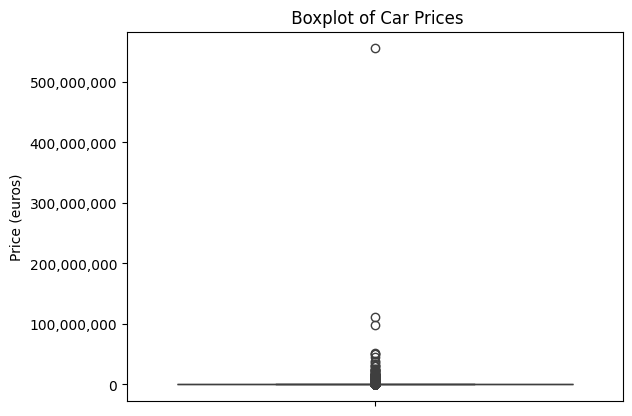

In [6]:
# Remove rows with missing prices
df = df[df['price'].notnull()]

# Boxplot to find outliers
sns.boxplot(y=df['price'])
sns.set_style("darkgrid")
sns.set_palette("muted")
plt.title(" Boxplot of Car Prices")
plt.ylabel("Price (euros)")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

As we can see there are many outliers, let's remove them with the 99th percentile method, but let's for curiosity's sake also check what brand these cars are, as these prices may even be valid for brands like Bugatti, or museal pieces.


Number of rows after removing outliers: 495433
Removed: 10182 rows (2.01%)


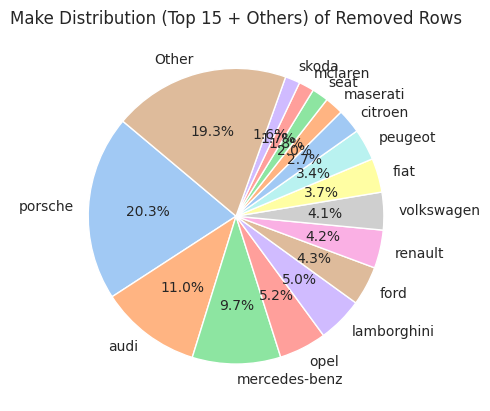

In [7]:
# Remove outliers on both ends
upper_price_threshold = df['price'].quantile(0.99)
lower_price_threshold = df['price'].quantile(0.01)
df_cleaned = df[(df['price'] < upper_price_threshold) &
                (df['price'] > lower_price_threshold)].copy()
print(
    f"Number of rows after removing outliers: {len(df_cleaned)}\nRemoved: {len(df) - len(df_cleaned)} rows ({round(100 - len(df_cleaned) / len(df) * 100, 2)}%)")

# See the make distribution of the removed rows
df_removed = pd.concat([df, df_cleaned]).drop_duplicates(keep=False)
top_n = 15
make_counts = df_removed['make'].value_counts()
top_makes = make_counts.head(top_n)
other_count = make_counts.iloc[top_n:].sum()
top_makes['Other'] = other_count

plt.pie(
    top_makes,
    labels=top_makes.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel"),
)
plt.title("Make Distribution (Top 15 + Others) of Removed Rows")
plt.show()

# Check car with the highest price
# highest_price_row = df.loc[df['price'].idxmax()]
# print("\nCar with the highest price:")
# print(highest_price_row[['car_title', 'price', 'url']])

Removing the outliers left us with 10371 fewer rows, which in case of such a large dataset may not be too bad. Only 2.05% as expected for the 1/99 quantile.

As we can see many of the outliers are from premium car brands, supposedly the ones above the 99th percentile and we can also see that many popular brands show up with a few percentage points, these supposedly below the 1 percentile threshold.

Porsche is one of the biggest outliers, which is understandable as it is both a popular brand and has many retro / museal pieces.

Lamborghini however is concerning to see here as it is almost 5% of the outliers, which may be a significant portion of the brand's cars. For now it is fine but we have to take this into consideration when later for example building prediction models.

Let's see the boxplot again.


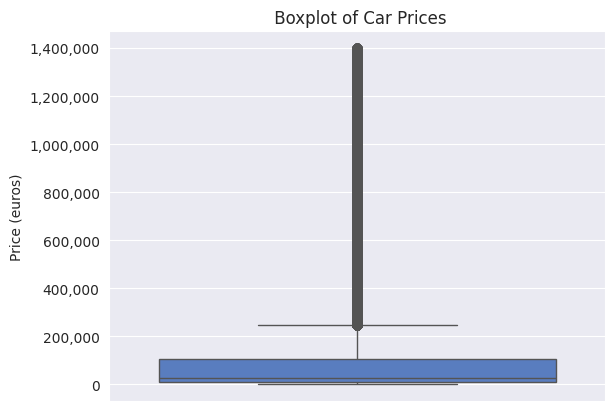

In [8]:
sns.boxplot(y=df_cleaned['price'])
sns.set_style("darkgrid")
sns.set_palette("muted")
plt.title(" Boxplot of Car Prices")
plt.ylabel("Price (euros)")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

We can still see that there is a significant amount of outliers above, but our plot is looking a bit nicer now and 1.4 million is a bit more realistic. As usual with prices, it is very positively skewed and should be handled later when building models, this can also be seen on the barplot.


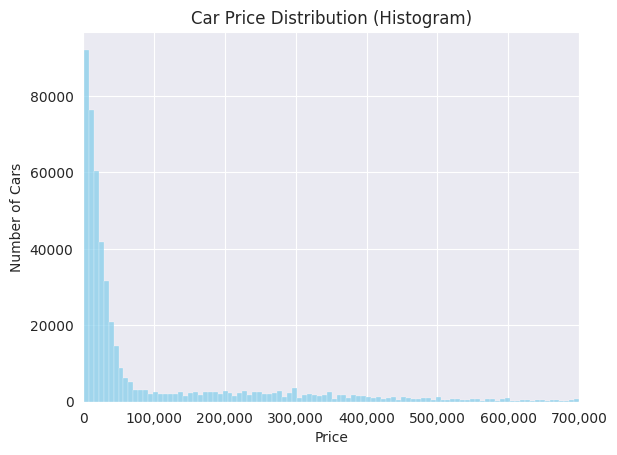

In [9]:
# Make a histplot of the cleaned prices
num_bins = 200
# plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['price'], bins=num_bins, kde=False,
             color="skyblue")  # Use histplot
plt.title("Car Price Distribution (Histogram)")
plt.xlabel("Price")
plt.ylabel("Number of Cars")
plt.xlim(0, 700000)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Visually Exploring how Other Features Relate to Price

### Price VS Age - Visually

One of the main probable factors is the age of the car, however we have it as the day of of the registration in ISO %Y-%m format. Let's create a new column that is the age.

In [10]:
# Turn the 'first_registration' column into a datetime object
df_cleaned['first_registration'] = pd.to_datetime(
    df_cleaned['first_registration'],
    format='%Y-%m', errors='coerce'
)

# Create age (years) and age_months (months) columns
# current_year = pd.Timestamp.now().year
# df_cleaned['age'] = current_year - df_cleaned['first_registration'].dt.year
current_date = pd.to_datetime('now')
df_cleaned['age_months'] = (current_date.year - df_cleaned['first_registration'].dt.year) * \
    12 + (current_date.month - df_cleaned['first_registration'].dt.month)

# Drop the 'first_registration' column
df_cleaned.drop(columns=['first_registration'], inplace=True, axis=1)

Now let's quickly visualize the age distribution then take a look at how it correlates with the price of the car.

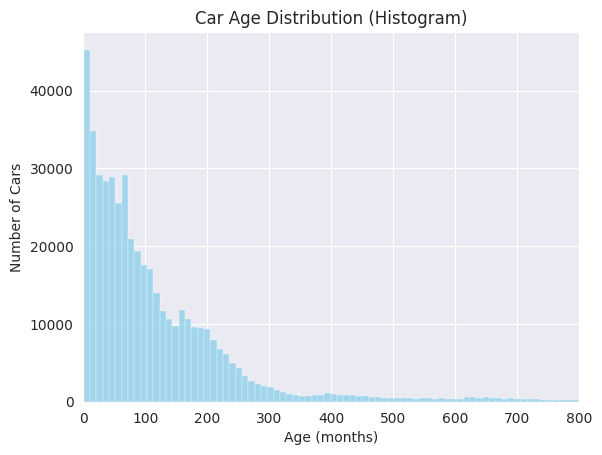


Age (months) summary statistics:
count   467135.00
mean       117.64
std        133.22
min        -30.00
25%         34.00
50%         77.00
75%        159.00
max       1503.00
Name: age_months, dtype: float64


In [11]:
# Make a histplot of the age of cars in months
num_bins = 150
# plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['age_months'], bins=num_bins, kde=False,
             color="skyblue")  # Use histplot
plt.title("Car Age Distribution (Histogram)")
plt.xlabel("Age (months)")
plt.ylabel("Number of Cars")
plt.xlim(0, 800)
plt.show()

# Describe the age_months column
print("\nAge (months) summary statistics:")
print(df_cleaned['age_months'].describe())

We can see that it is similarly to the price, positively skewed, there are a lot more newer cars than older cars, we can also see that there might be a few bad entries as the minimum age is -30 months. Let's get rid fo these as it may be valid, some dealers may state that it will be ready for registration by then, but of course in our case of measuring age it is not a valid value. It turns out to be an insignificant amount of records so we might as well drop them.

In [12]:
# Get the count of values where age_months or age is negative
negative_age_months_count = df_cleaned[df_cleaned['age_months'] < 0].shape[0]
print("Number of negative age_months values:", negative_age_months_count)
# df_cleaned[df_cleaned['age_months'] < 0].head(10)

# Drop the rows with negative age_months
df_cleaned = df_cleaned[df_cleaned['age_months'] >= 0]

Number of negative age_months values: 213


Now after having removed these values, let's check how age and price are related.

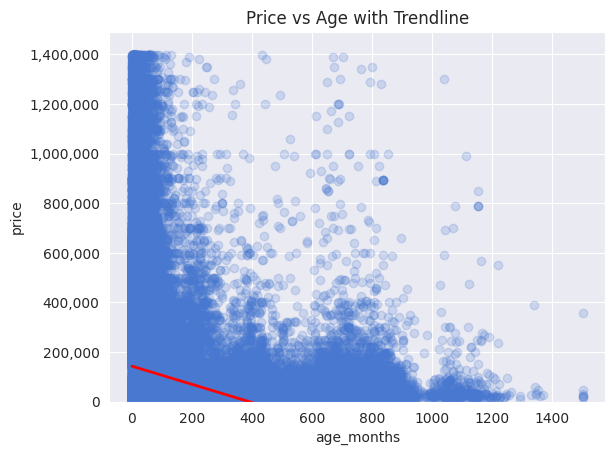

In [13]:
# Price VS Age scatter
sns.regplot(
    x='age_months',
    y='price',
    data=df_cleaned,
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'red', 'linewidth': 2},  # Customize trendline color and thickness
    order=1,  # Polynomial order of the trendline (1 for linear)
    truncate=True # Truncate the trendline within the data range
)
plt.title("Price vs Age with Trendline")
# plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(bottom=0)  # Set the y-axis minimum to 0
plt.show()

Using a regression plot we can see that there is a clear negative relationship between the two values.

### Price VS Make - Visually

Here we may check which brands are the most / least expensive and how they are distributed.

<ipython-input-14-b411dc1baf45>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_prices.index, y=make_prices.values, palette='viridis')


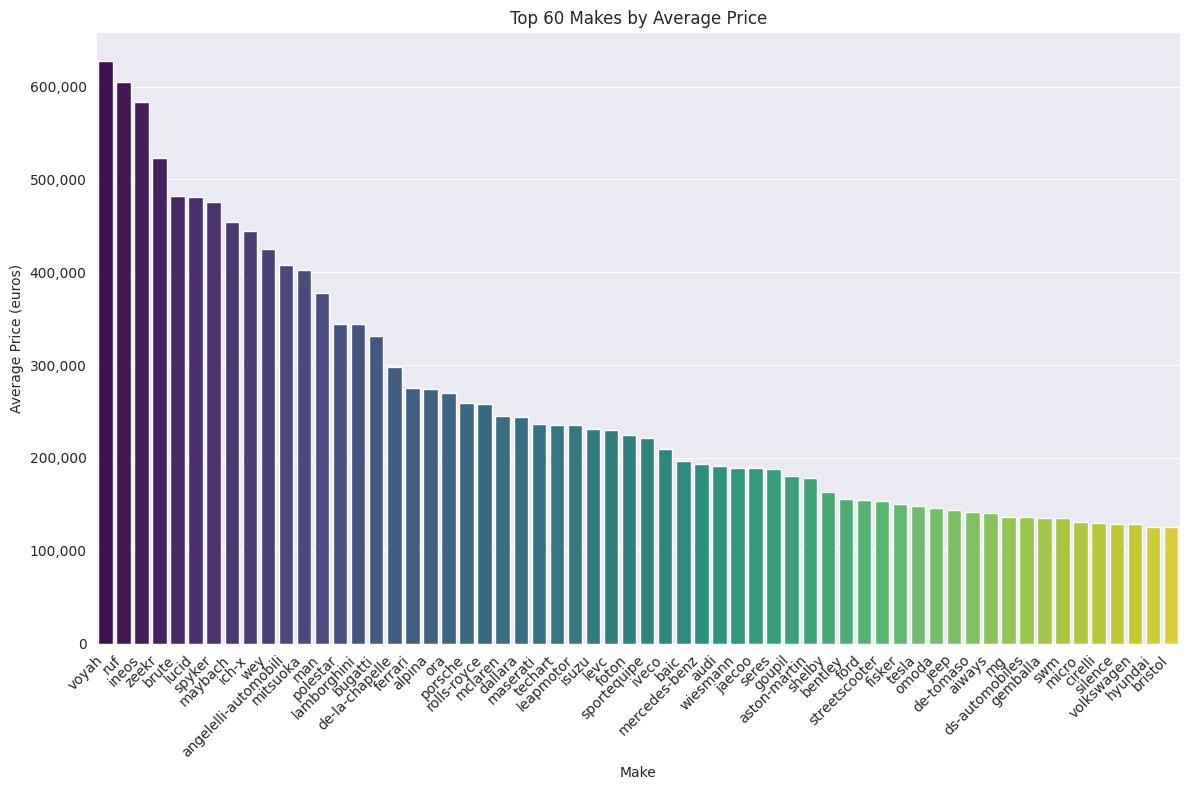

In [14]:
# Barplot of car prices grouped by make
top_n = 60  # Limit to top 15 makes for readability
make_prices = df_cleaned.groupby('make')['price'].mean().sort_values(ascending=False).head(top_n)

plt.figure(figsize=(12, 8))  # Increase figure size
sns.barplot(x=make_prices.index, y=make_prices.values, palette='viridis')
plt.title(f"Top {top_n} Makes by Average Price")
plt.xlabel("Make")
plt.ylabel("Average Price (euros)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}')) # Apply formatting to y axis
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

Interestingly many of the top brands are rather unknown and we can also see some interesting entries, like Polestart being on average more expensive than Bugatti and Ferrari.

<ipython-input-15-60b608917bdb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=make_prices.index, y=make_prices.values, palette='viridis')


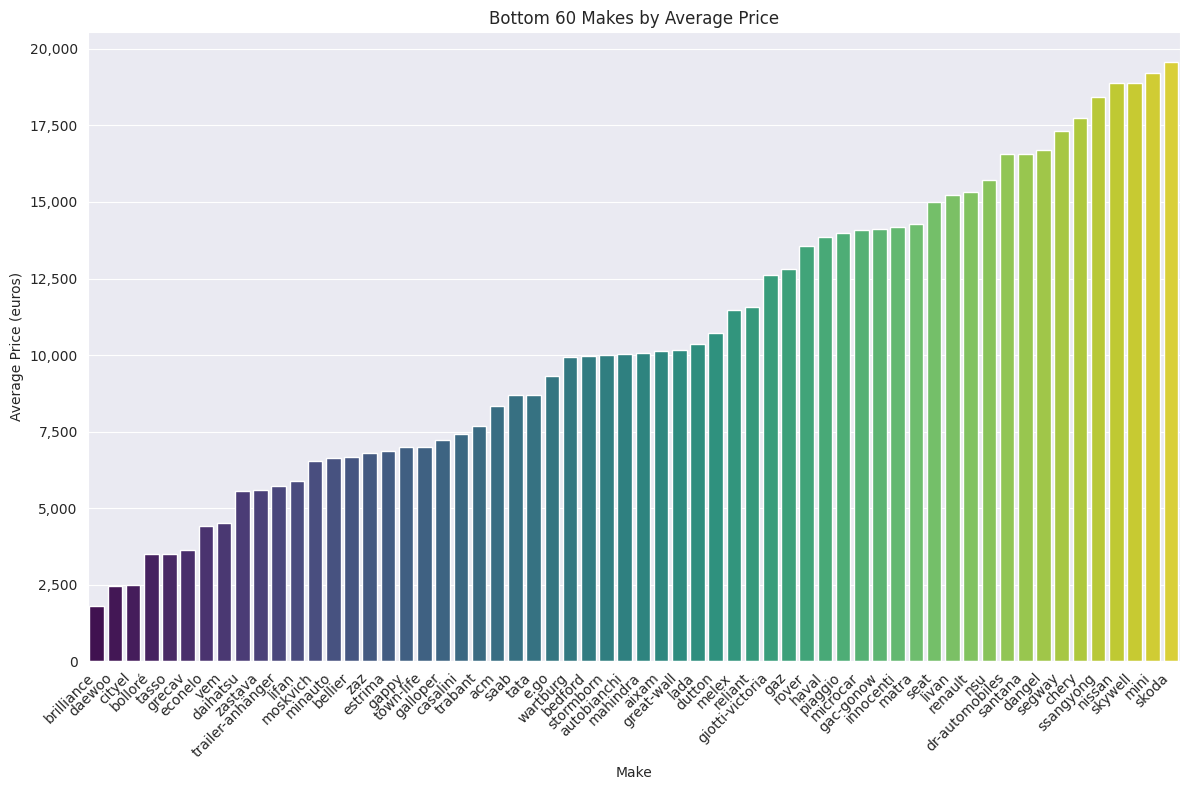

In [15]:
# Barplot of car prices grouped by make
bottom_n = 60  # Limit to top 15 makes for readability
make_prices = df_cleaned.groupby('make')['price'].mean().sort_values(ascending=True).head(bottom_n)

plt.figure(figsize=(12, 8))  # Increase figure size
sns.barplot(x=make_prices.index, y=make_prices.values, palette='viridis')
plt.title(f"Bottom {bottom_n} Makes by Average Price")
plt.xlabel("Make")
plt.ylabel("Average Price (euros)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}')) # Apply formatting to y axis
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

For the bottom 60 we can see many mobility scooter and chinese brands as expercted before finding reuglar mid-range brands like Renault or Skoda. We will later check the relations numerically, for now here is one more visualization showing that we may be able to distinguish patterns of makes in such a plot as Price VS Age by Make.

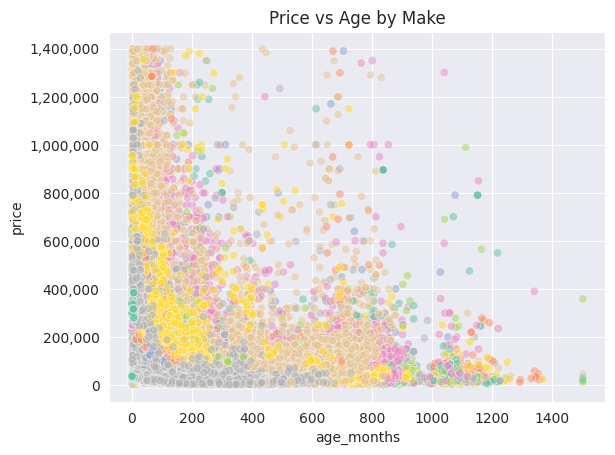

In [16]:
# Price VS Age scatter plot hue by make
sns.scatterplot(
    x='age_months',
    y='price',
    hue='make',
    data=df_cleaned,
    alpha=0.5,
    palette="Set2",
    legend=False
)
plt.title("Price vs Age by Make")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Numerically Exploring how Other Features Relate to Price

### Correlation Analysis of Numerical Values

#### Preparing Data

We have some features that should actually be numeric, but don't seem to be stored as such, let's see if we can convert them. Namely:

- seats
- doors
- gears
- cylinders
- fuel_consumption (needs special care, form is `6.7 l/100 km (comb.)`)

In [17]:
# Convert 'fuel_consumption' column
def convert_fuel_consumption(val):
    """
    Convert a string like '6.7 l/100 km (comb.)' into a float (6.7).
    If conversion fails or the value is missing, return np.nan.
    """
    if pd.isna(val):
        return np.nan
    match = re.search(r"[\d\.]+", val)
    if match:
        try:
            return float(match.group())
        except ValueError:
            return np.nan
    return np.nan

if df_cleaned['fuel_consumption'].dtype != 'float64':
    df_cleaned['fuel_consumption'] = df_cleaned['fuel_consumption'].apply(
        convert_fuel_consumption)


# Turn other columns to numeric type
numeric_cols = ['seats', 'doors', 'gears', 'cylinders']
for col in numeric_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

#  Validate the conversion
df_cleaned[["fuel_consumption", *numeric_cols]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 466922 entries, 0 to 505800
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fuel_consumption  179322 non-null  float64
 1   seats             433518 non-null  float64
 2   doors             452976 non-null  float64
 3   gears             293010 non-null  float64
 4   cylinders         338680 non-null  float64
dtypes: float64(5)
memory usage: 21.4 MB


#### Correlation Analysis

Due to the fact that many of our main variables like Price, Age and Mileage are not at all normally distributed, I will be using Spearman's instead of the default Pearson's statistics.

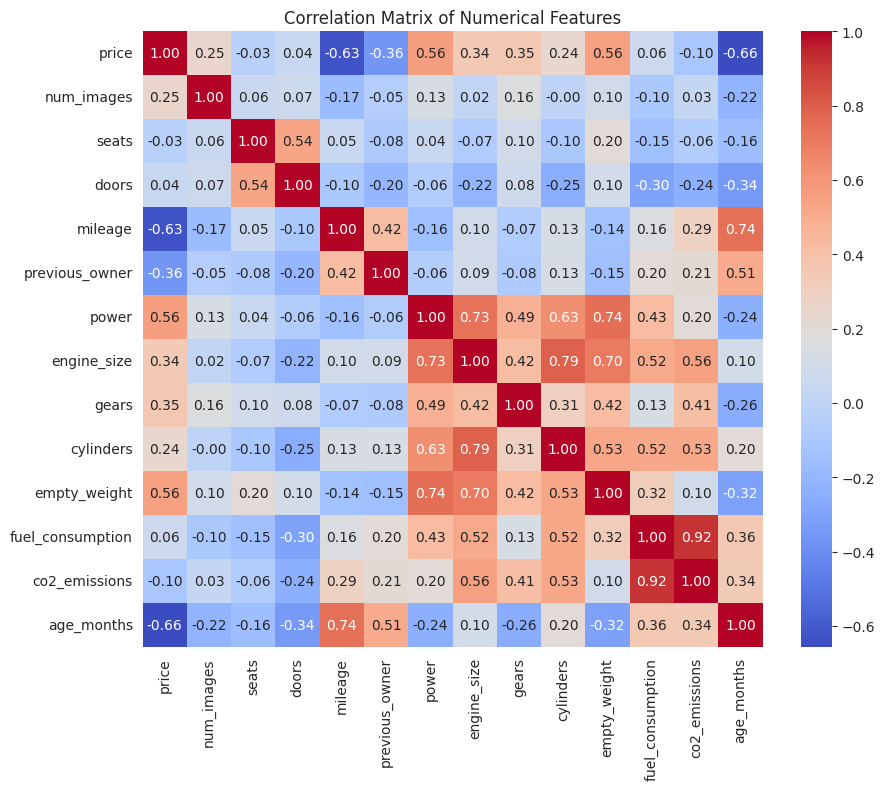

In [18]:
# Create the correlation matrix
correlation_matrix = df_cleaned.corr(method="spearman", numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# correlation_matrix.price.sort_values(ascending=False)

The correlation analysis shows us some interesting information. Namely the following:

- **Power (0.56)**: Moderately positive. Higher engine power tends to be associated with higher prices.
- **Empty Weight (0.56)**: Also moderately positive. Heavier cars tend to be more expensive, which might reflect larger, more luxurious vehicles.
- **Engine Size (0.34)**: A moderate, but weaker, positive relationship. Larger engines generally correlate with higher pricing, though this effect is less pronounced than power or weight.
- **Num Images (0.25)**: A low positive correlation. This may indicate that listings with more images are for higher-priced (perhaps premium) vehicles.
- **CO2 Emissions (-0.10)**: Almost negligible. CO2 emissions don’t have a strong monotonic effect on price.
- **Previous Owner (-0.36)**: A moderate negative relationship suggests that cars with more previous owners tend to have lower prices.
- **Mileage (-0.63)**: A strong negative correlation. As mileage increases, the price tends to drop considerably. This highlights how important the usage factor is.
- **Age (age_months) (-0.66)**: Also a strong negative relationship—older cars (in months) tend to be priced lower.

This is mostly as expected, Age, Mileage and Power are the biggest numerical factors, however we can also see that many of our factors are greatly correlated with each other. The three biggest blocks are:

- `Size and Performance`: Power / Engine Size / Empty Weight / Gears... (the bigger the car and more empty weight it has, the more power it generally needs and the more powerful a car is, usually the engine size is also bigger)
- `Age Related`: Age / Mileage / Previouse Owner (the older a vehicle, the more likely it has run more distance and had more owners)
- `Emissions`: co2_emission / fuel_consumption

### Analysis of Non-numeric Factors

#### Preparing Data

To properly analyze some of our factors we will have to split composit factors and 1-hot encode them, this is true for the columns: `['comfort_and_convenience', 'entertainment_and_media', 'safety_and_security', 'extras']`

In [19]:
df_cleaned_split = df_cleaned.copy()


def process_semicolon_column(df, colname, delimiter=';'):
    """
    Splits a column with delimiter-separated values into a new list column and encodes it.
    Missing values are left as missing (None).
    """
    # Create a new column with lists for non-missing values
    new_colname = f"{colname}_list"

    def split_values(val):
        if pd.isna(val):
            return None  # Leave missing values as None
        return [item.strip() for item in val.split(delimiter) if item.strip()]

    df[new_colname] = df[colname].apply(split_values)

    # Encode non-missing rows using MultiLabelBinarizer
    not_missing = df[new_colname].notna()
    if not not_missing.any():
        print(f"No non-missing values found in {colname}")
        return df

    mlb = MultiLabelBinarizer()
    encoded = pd.DataFrame(mlb.fit_transform(df.loc[not_missing, new_colname]),
                           columns=mlb.classes_,
                           index=df.loc[not_missing].index)

    # Merge the encoded columns back into the original DataFrame
    df = pd.concat([df, encoded], axis=1)
    return df

# Process the semicolon-separated columns
columns_to_process = ['comfort_and_convenience',
                      'entertainment_and_media', 'safety_and_security', 'extras']
# columns_to_process = ['entertainment_and_media', 'safety_and_security', 'extras']

for col in columns_to_process:
    df_cleaned_split = process_semicolon_column(df_cleaned_split, col)
    df_cleaned_split.drop(columns=[col, f"{col}_list"], inplace=True)


Moreover, `location` feature could be interesting, but in the current form a of city + country code (Lokeren , BE) it may just be too fine grained, we should also change this one so that we only have the country codes.

In [20]:
# Go through each car, if location is available, set it to just the country code.
df_cleaned_split['location'] = df_cleaned_split['location'].apply(
    lambda loc: loc.split(', ')[-1].strip() if pd.notna(loc) else None
)
df_cleaned_split['location'] = df_cleaned_split['location'].str.extract(r'([A-Za-z]{2})')

Of course since prices are always positively skewed, they will also be positively skewed when looking at it a by country bases, but we can see slight differences, expecially in the cases of Germany and Luxembourg.

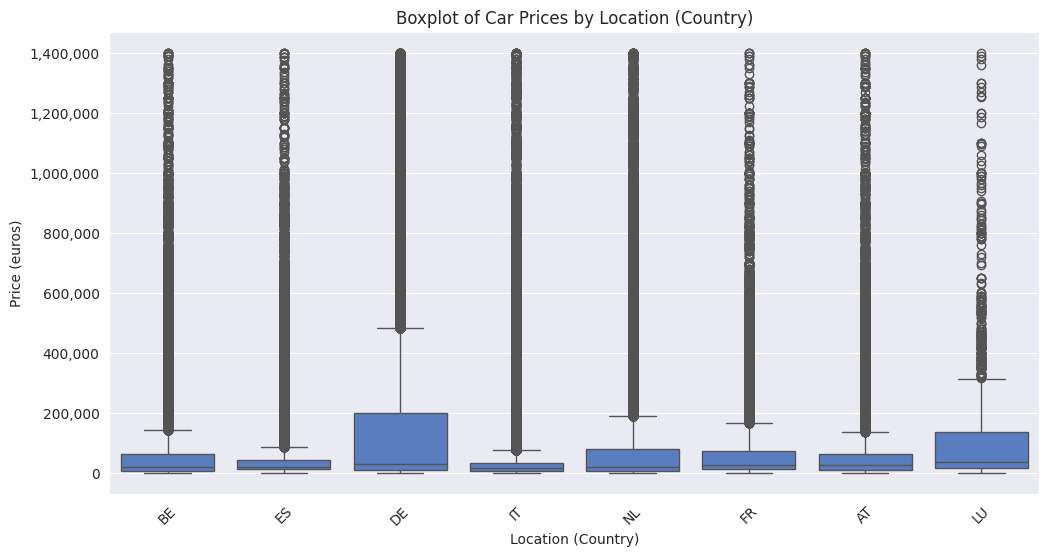

location
DE    166529
IT     98439
NL     72233
ES     47706
BE     30950
FR     26574
AT     22680
LU      1788
Name: count, dtype: int64


In [21]:
# Boxplot for price by location (country)
plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='price', data=df_cleaned_split)
plt.title("Boxplot of Car Prices by Location (Country)")
plt.xlabel("Location (Country)")
plt.ylabel("Price (euros)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()
# Check the distribution of the location column
print(df_cleaned_split['location'].value_counts())

#### Feature Importance Analysis

Since there are so many possible categorical variables we need to remove some that we know we could not possibly compute in a reasonable amount of time. Such as `car_title` for example, although removing that one may also semantically make sense.

In [22]:
X = df_cleaned_split.drop(columns=['price'])
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in X.columns:
    # print(f"{col}: {X[col].dtype}")
    if col not in numerical_cols:
        print(f"{col}: {X[col].nunique()} unique values")

make: 225 unique values
car_title: 2894 unique values
seller: 3 unique values
location: 8 unique values
body_type: 30 unique values
used_type: 6 unique values
drivetrain: 3 unique values
full_service_history: 1 unique values
non_smoker_service: 0 unique values
gearbox: 3 unique values
fuel_type: 11 unique values
emission_class: 11 unique values
emissions_sticker: 4 unique values
exterior_colour: 14 unique values
paint: 2 unique values
upholstery_colour: 11 unique values
upholstery: 6 unique values


Let's train the model with some random hyperparameter tuning, subsampling of our dataset and random search to make it feasible.

In [23]:
# Sample a subset of your data for quick experimentation
np.random.seed(42)  # For reproducibility
sample_size = 15000  # Adjust for balance between speed and representativeness
df_sample = df_cleaned_split.sample(n=sample_size, random_state=42)

# Prepare features excluding high-cardinality 'car_title'
X_sample = df_sample.drop(columns=['price', 'car_title'])
X_sample = pd.get_dummies(X_sample, drop_first=True)
y_sample = df_sample['price']

# Split the sample
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

In [24]:
# Use RandomizedSearchCV with parallel processing to tune the RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42)

Now let's see the top features.

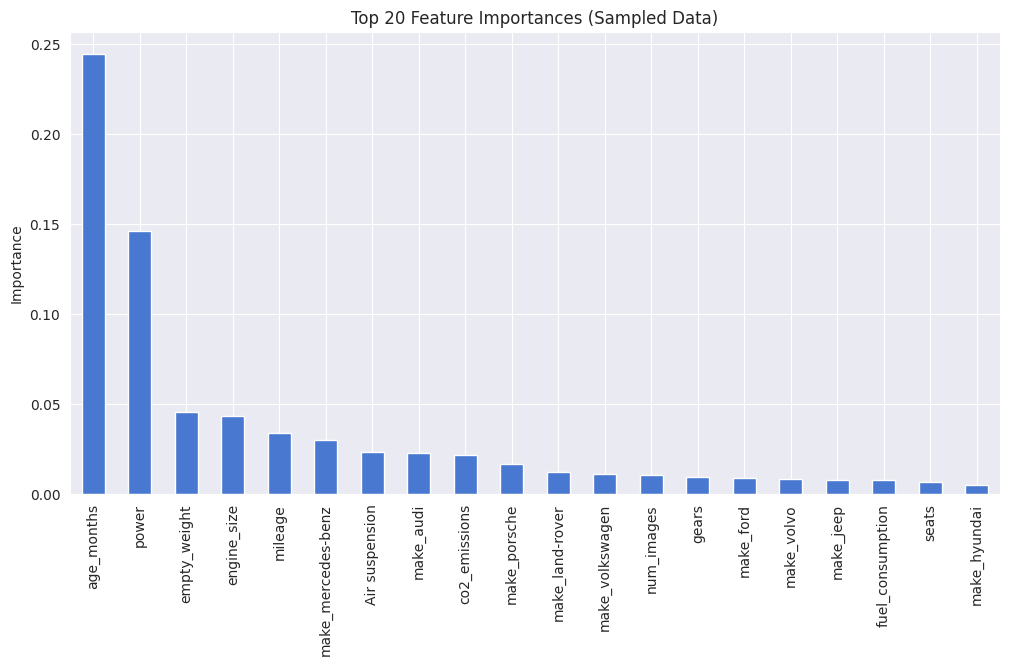

In [25]:
# Get the importances
# Retrieve the best estimator and its feature importances
best_rf = random_search.best_estimator_
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# print(feature_importances.head(20))

# Visualize the top features
plt.figure(figsize=(12, 6))
feature_importances.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Sampled Data)")
plt.ylabel("Importance")
plt.show()

Not so surprisingly `age_months` and `power` are our only main notable factors, in greater detail:

- age_months (0.24) and power (0.15): These are the strongest predictors. It suggests that a car’s age and its engine power have the largest influence on pricing in your dataset.
- empty_weight (0.05) and engine_size (0.05): These factors are moderately important, which aligns with the idea that larger or heavier cars (often more luxurious) tend to cost more.
- mileage (0.04): Although many would expect mileage to be highly important, its lower ranking here could be due to its possibly non-linear or complex relationship with price that the RandomForest isn’t capturing as strongly. Feature engineering (e.g., binning or transforming mileage) might be needed to see its effects more clearly.
- make categories (e.g. make_audi, make_mercedes-benz, etc.): These dummy variables indicate the effect of each brand relative to the baseline category (which is dropped when you use get_dummies with drop_first=True). Their individual importance tells you how much that specific brand adjusts the expected price. It doesn’t mean that these “combine” into one overall make effect—as a model, RandomForest treats each dummy variable separately. The fact that several makes have non-negligible importance means that the brand effect is indeed relevant, and each brand contributes differently to the price.

In summary, the feature importance output confirms that age and power are key determinants of price, while the contribution of mileage may be muted because its relationship with price might be non-linear or overshadowed by other correlated features. The make-related features simply capture the brand-specific adjustments in price rather than a combined “true power” of the make category

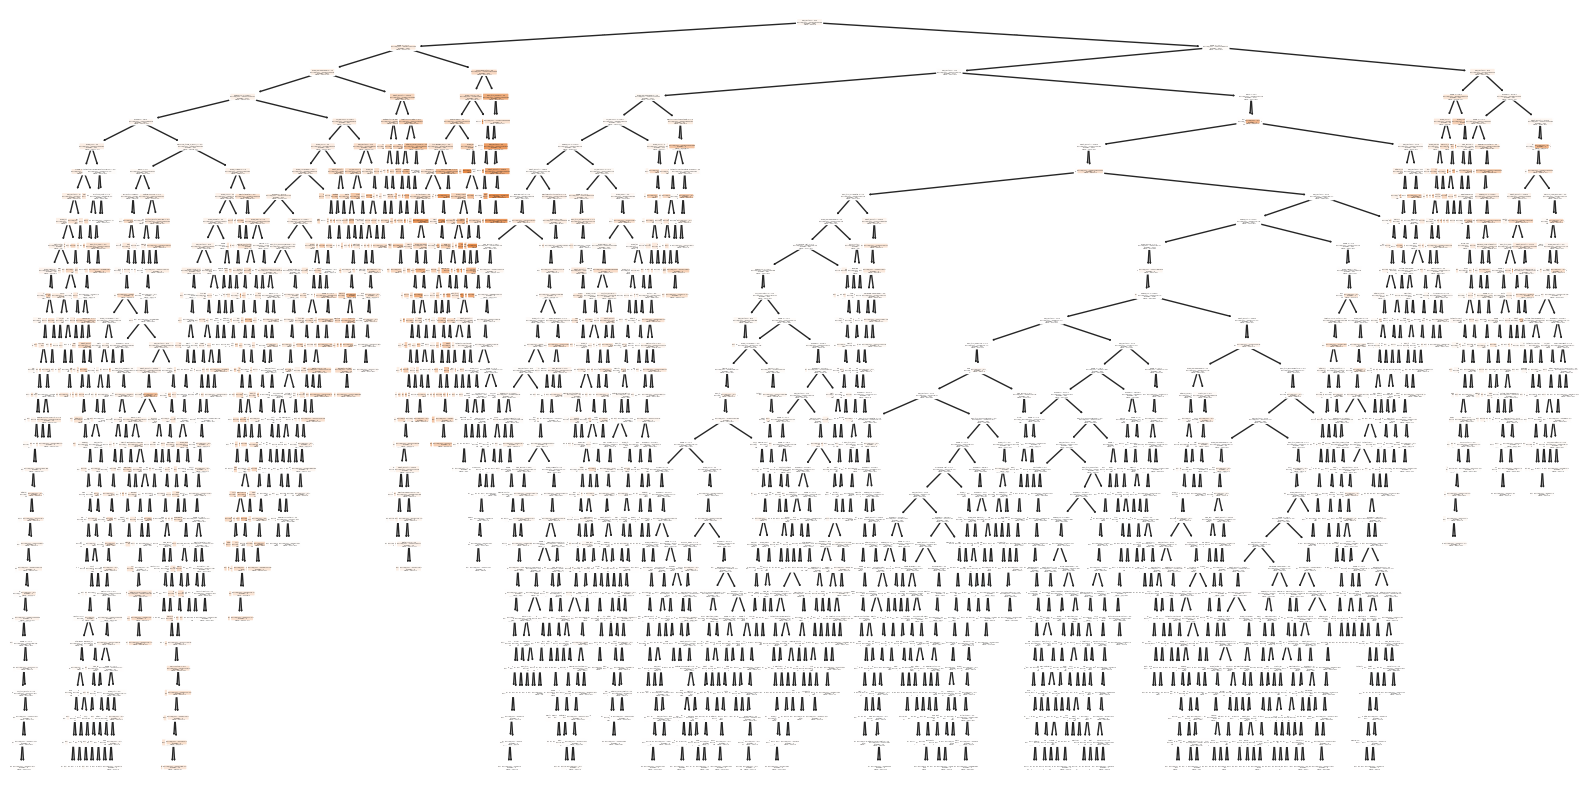

In [26]:
# Plot tree
plt.figure(figsize=(20,10))
# Plot the first tree from the forest (for example)
tree.plot_tree(best_rf.estimators_[0],
               feature_names=X_train.columns,
               filled=True,
               rounded=True)
plt.show()

In [27]:
# Get statistics
y_pred_ensemble = best_rf.predict(X_test)

# Calculate R² and RMSE for the full forest
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print("Full RandomForest performance:")
print(f"R² score: {r2_ensemble:.3f}")
print(f"RMSE: {rmse_ensemble:.2f}")

# Alternatively, use the built-in score method (which returns R²)
ensemble_r2 = best_rf.score(X_test, y_test)
print(f"Ensemble R² (using score method): {ensemble_r2:.3f}")

Full RandomForest performance:
R² score: 0.624
RMSE: 112472.13
Ensemble R² (using score method): 0.624


## Building a Predictive Model

### XGBoost

In [28]:
# Build an XGBoost model
import xgboost as xgb

# Create and fit the model
xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1  # You can tune this further
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("XGBoost performance:")
print(f"R² score: {r2_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.2f}")

XGBoost performance:
R² score: 0.645
RMSE: 109302.47


## Log-transformed Analysis

Due to the strongly positively skewed nature of many of our variables we have previously tried using Spearman's correlation, but another route we can take is trying to log-transform these columns and then try and build our models.

In [ ]:
# TODO: Do the same things as before, but log-transformed dataframe